In [1]:
pip install yfinance

  Created wheel for yfinance: filename=yfinance-0.1.54-py2.py3-none-any.whl size=22409 sha256=14e19f3d699dcfbc400821c0ab56a32eabd211bad175ab4c6f39a5379a37ee0a
  Stored in directory: /root/.cache/pip/wheels/f9/e3/5b/ec24dd2984b12d61e0abf26289746c2436a0e7844f26f2515c
Successfully built yfinance


**Import Libraries**

In [2]:
import yfinance as yf

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm



import pandas_datareader as pdd
import pandas_datareader.data as web
from datetime import datetime, date
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import minmax_scale
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, LSTM, Input, concatenate, Embedding, Reshape
import keras
import keras.backend as K
import tensorflow as tf



%matplotlib inline
sns.set()


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [3]:
np.random.seed(42)
K.clear_session()

In [4]:
from numpy.random import seed
seed(7)
tf.random.set_seed(7)

**Data Cleaning and Exploration**

In [5]:
#define the tickers list
#Edison International, Sempra Energy, Tesla, Pacific Gas and Electric, NextEra Energy, Brookfield Renewable Partners
tickers_list = ['EIX', 'SRE', 'TSLA', 'PCG', 'NEE', 'BEP']

In [6]:
main_data=yf.download(tickers_list,start='2010-6-30',end='2020-7-21')

[*********************100%***********************]  6 of 6 completed


In [7]:
main_data.head()

Adj Close                        ...     Volume                       
                 BEP        EIX        NEE  ...        PCG        SRE        TSLA
Date                                        ...                                  
2010-06-30  9.647870  22.918180  35.278999  ...  2169100.0  2094000.0  17187100.0
2010-07-01  9.647870  22.621950  35.416481  ...  3150800.0  2130000.0   8218800.0
2010-07-02  9.601758  22.491901  35.423706  ...  2055400.0  1440100.0   5139800.0
2010-07-06  9.596629  22.766451  35.742054  ...  1875700.0  1303900.0   6866900.0
2010-07-07  9.704230  23.561220  36.754993  ...  2526800.0  1562300.0   6921700.0

[5 rows x 36 columns]

In [8]:
main_data.tail()

Adj Close                         ...      Volume                       
                  BEP        EIX         NEE  ...         PCG        SRE        TSLA
Date                                          ...                                   
2020-07-14  51.650002  56.669998  262.549988  ...  16119500.0  2113600.0  23418100.0
2020-07-15  53.439999  55.279999  259.000000  ...  19555600.0  2277000.0  16367800.0
2020-07-16  53.459999  56.090000  268.380005  ...  17867200.0  1372100.0  14300800.0
2020-07-17  55.730000  56.360001  275.380005  ...  19234100.0  1936100.0   9330000.0
2020-07-20  55.820000  54.889999  274.329987  ...  17643400.0  1228600.0  17121400.0

[5 rows x 36 columns]

In [9]:
main_data.to_csv('main_data.csv',index=True)

Retrieve dataframe with just the Close

In [10]:
close_data=yf.download(tickers_list,start='2010-6-30',end='2020-7-20')['Close']

[*********************100%***********************]  6 of 6 completed


In [11]:
close_data.head()

,BEP,EIX,NEE,PCG,SRE,TSLA
Date,,,,,,
2010-06-30,18.830000,31.719999,48.759998,41.099998,46.790001,23.830000
2010-07-01,18.830000,31.309999,48.950001,40.840000,46.430000,21.959999
2010-07-02,18.740000,31.129999,48.959999,40.730000,46.509998,19.200001
2010-07-06,18.730000,31.510000,49.400002,41.389999,47.060001,16.110001
2010-07-07,18.940001,32.610001,50.799999,42.259998,48.490002,15.800000


In [12]:
#data info
close_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2531 entries, 2010-06-30 to 2020-07-17
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   BEP     2530 non-null   float64
 1   EIX     2530 non-null   float64
 2   NEE     2530 non-null   float64
 3   PCG     2530 non-null   float64
 4   SRE     2530 non-null   float64
 5   TSLA    2530 non-null   float64
dtypes: float64(6)
memory usage: 138.4 KB


In [16]:
#export data for editing
close_data.to_csv('close_data.csv',index=True)

Importing the new dataframe after we have introduced the new dummy variables

In [17]:
#import the new file
data=pd.read_csv('close_data_dummies.csv')

In [18]:
data.head()

,Date,BEP,EIX,NEE,PCG,SRE,TSLA,Day,Week_Day,Week_Num,Month,Year,Mon,Tue,Wed,Thur,Fri,Sat,Sun,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year_ID
0,6/30/10,18.830000,31.719999,48.759998,41.099998,46.790001,23.830000,30,4,27,6,2010,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1
1,7/1/10,18.830000,31.309999,48.950001,40.840000,46.430000,21.959999,1,5,27,7,2010,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
2,7/2/10,18.740000,31.129999,48.959999,40.730000,46.509998,19.200001,2,6,27,7,2010,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
3,7/6/10,18.730000,31.510000,49.400002,41.389999,47.060001,16.110001,6,3,28,7,2010,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1
4,7/7/10,18.940001,32.610001,50.799999,42.259998,48.490002,15.800000,7,4,28,7,2010,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1


In [19]:
#DataFrame Info
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2531 entries, 0 to 2530
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2531 non-null   object 
 1   BEP       2530 non-null   float64
 2   EIX       2530 non-null   float64
 3   NEE       2530 non-null   float64
 4   PCG       2530 non-null   float64
 5   SRE       2530 non-null   float64
 6   TSLA      2530 non-null   float64
 7   Day       2531 non-null   int64  
 8   Week_Day  2531 non-null   int64  
 9   Week_Num  2531 non-null   int64  
 10  Month     2531 non-null   int64  
 11  Year      2531 non-null   int64  
 12  Mon       2531 non-null   int64  
 13  Tue       2531 non-null   int64  
 14  Wed       2531 non-null   int64  
 15  Thur      2531 non-null   int64  
 16  Fri       2531 non-null   int64  
 17  Sat       2531 non-null   int64  
 18  Sun       2531 non-null   int64  
 19  Jan       2531 non-null   int64  
 20  Feb       2531 non-null   int6

In [20]:
#summary of data
data.describe()

,BEP,EIX,NEE,PCG,SRE,TSLA,Day,Week_Day,Week_Num,Month,Year,Mon,Tue,Wed,Thur,Fri,Sat,Sun,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year_ID
count,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2530.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.0,2531.0,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000,2531.000000
mean,30.046557,57.494162,118.836324,43.562245,95.922538,215.445435,15.715923,4.024101,27.048202,6.541288,2015.016989,0.187673,0.204662,0.204662,0.201896,0.201106,0.0,0.0,0.080601,0.075859,0.085737,0.081786,0.084552,0.084552,0.088107,0.088107,0.080205,0.086922,0.080996,0.082576,6.016989
std,6.108211,13.401390,56.114268,15.127931,27.028766,184.932700,8.748817,1.400668,14.925879,3.416794,2.931515,0.390528,0.403534,0.403534,0.401495,0.400907,0.0,0.0,0.272274,0.264825,0.280030,0.274092,0.278268,0.278268,0.283507,0.283507,0.271665,0.281777,0.272882,0.275295,2.931515
min,18.730000,31.129999,48.759998,3.800000,45.590000,15.800000,1.000000,2.000000,1.000000,1.000000,2010.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,26.865000,45.972501,71.302502,41.110001,71.959999,35.152501,8.000000,3.000000,14.000000,4.000000,2013.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000
50%,29.480000,58.945000,103.470001,44.860001,102.435001,218.394997,16.000000,4.000000,27.000000,7.000000,2015.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000
75%,31.340000,68.447498,155.084999,52.580002,113.035000,285.495003,23.000000,5.000000,40.000000,10.000000,2018.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,9.000000
max,56.950001,82.639999,282.220001,71.559998,161.130005,1546.010010,31.000000,6.000000,53.000000,12.000000,2020.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,11.000000


In [21]:
data.isnull().any()

Date        False
BEP          True
EIX          True
NEE          True
PCG          True
SRE          True
TSLA         True
Day         False
Week_Day    False
Week_Num    False
Month       False
Year        False
Mon         False
Tue         False
Wed         False
Thur        False
Fri         False
Sat         False
Sun         False
Jan         False
Feb         False
Mar         False
Apr         False
May         False
Jun         False
Jul         False
Aug         False
Sep         False
Oct         False
Nov         False
Dec         False
Year_ID     False
dtype: bool

In [22]:
print(data[data['BEP'].isnull()==True])
print(data[data['EIX'].isnull()==True])
print(data[data['NEE'].isnull()==True])
print(data[data['PCG'].isnull()==True])
print(data[data['SRE'].isnull()==True])
print(data[data['TSLA'].isnull()==True])

         Date  BEP  EIX  NEE  PCG  SRE  ...  Aug  Sep  Oct  Nov  Dec  Year_ID
1740  5/29/17  NaN  NaN  NaN  NaN  NaN  ...    0    0    0    0    0        8

[1 rows x 32 columns]
         Date  BEP  EIX  NEE  PCG  SRE  ...  Aug  Sep  Oct  Nov  Dec  Year_ID
1740  5/29/17  NaN  NaN  NaN  NaN  NaN  ...    0    0    0    0    0        8

[1 rows x 32 columns]
         Date  BEP  EIX  NEE  PCG  SRE  ...  Aug  Sep  Oct  Nov  Dec  Year_ID
1740  5/29/17  NaN  NaN  NaN  NaN  NaN  ...    0    0    0    0    0        8

[1 rows x 32 columns]
         Date  BEP  EIX  NEE  PCG  SRE  ...  Aug  Sep  Oct  Nov  Dec  Year_ID
1740  5/29/17  NaN  NaN  NaN  NaN  NaN  ...    0    0    0    0    0        8

[1 rows x 32 columns]
         Date  BEP  EIX  NEE  PCG  SRE  ...  Aug  Sep  Oct  Nov  Dec  Year_ID
1740  5/29/17  NaN  NaN  NaN  NaN  NaN  ...    0    0    0    0    0        8

[1 rows x 32 columns]
         Date  BEP  EIX  NEE  PCG  SRE  ...  Aug  Sep  Oct  Nov  Dec  Year_ID
1740  5/29/17  NaN  NaN  Na

In [23]:
data.iloc[[1740]]

,Date,BEP,EIX,NEE,PCG,SRE,TSLA,Day,Week_Day,Week_Num,Month,Year,Mon,Tue,Wed,Thur,Fri,Sat,Sun,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec,Year_ID
1740,5/29/17,NaN,NaN,NaN,NaN,NaN,NaN,29,2,22,5,2017,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,8


In [24]:
data.dropna(axis=0,inplace=True)

In [25]:
#DataFrame Row and Column shape
data.shape

(2530, 32)

In [26]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2530 entries, 0 to 2530
Data columns (total 32 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      2530 non-null   object 
 1   BEP       2530 non-null   float64
 2   EIX       2530 non-null   float64
 3   NEE       2530 non-null   float64
 4   PCG       2530 non-null   float64
 5   SRE       2530 non-null   float64
 6   TSLA      2530 non-null   float64
 7   Day       2530 non-null   int64  
 8   Week_Day  2530 non-null   int64  
 9   Week_Num  2530 non-null   int64  
 10  Month     2530 non-null   int64  
 11  Year      2530 non-null   int64  
 12  Mon       2530 non-null   int64  
 13  Tue       2530 non-null   int64  
 14  Wed       2530 non-null   int64  
 15  Thur      2530 non-null   int64  
 16  Fri       2530 non-null   int64  
 17  Sat       2530 non-null   int64  
 18  Sun       2530 non-null   int64  
 19  Jan       2530 non-null   int64  
 20  Feb       2530 non-null   int6

In [27]:
price=data.iloc[:,1:7]
price.head()

,BEP,EIX,NEE,PCG,SRE,TSLA
0,18.830000,31.719999,48.759998,41.099998,46.790001,23.830000
1,18.830000,31.309999,48.950001,40.840000,46.430000,21.959999
2,18.740000,31.129999,48.959999,40.730000,46.509998,19.200001
3,18.730000,31.510000,49.400002,41.389999,47.060001,16.110001
4,18.940001,32.610001,50.799999,42.259998,48.490002,15.800000


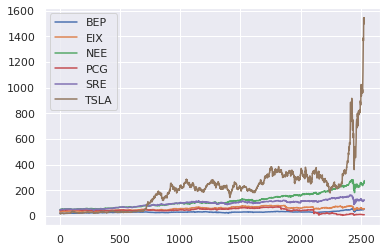

In [28]:
price.plot()

# **Prep Data**
**Scaling**

In [29]:
from sklearn.preprocessing import MinMaxScaler

In [30]:
scaler = MinMaxScaler()

In [31]:
scaler.fit(price)

MinMaxScaler(copy=True, feature_range=(0, 1))

In [32]:
xs = pd.DataFrame(scaler.transform(price), columns=price.columns, index=price.index)
xs.head()

,BEP,EIX,NEE,PCG,SRE,TSLA
0,0.002616,0.011454,0.000000,0.550472,0.010386,0.005248
1,0.002616,0.003494,0.000814,0.546635,0.007270,0.004026
2,0.000262,0.000000,0.000857,0.545012,0.007963,0.002222
3,0.000000,0.007377,0.002741,0.554752,0.012723,0.000203
4,0.005495,0.028732,0.008738,0.567591,0.025100,0.000000


**Reshape Data into RNN Format**


In [40]:
def create_multivariate_rnn_data(data, window_size):
    y = data[window_size:]
    n = data.shape[0]
    X = np.stack([data[i: j] for i, j in enumerate(range(window_size, n))], axis=0)
    return X, y

In [41]:
window_size = 5

In [42]:
X, y = create_multivariate_rnn_data(xs, window_size=window_size)

In [43]:
X.shape, y.shape

((2525, 5, 6), (2525, 6))

In [44]:
from sklearn.model_selection import train_test_split

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42,shuffle=False)

In [46]:
X_train.shape, X_test.shape

((1691, 5, 6), (834, 5, 6))

**Defining the Model Architecture**

In [47]:
n_features = output_size = 6

In [66]:
lstm1_units = 200
lstm2_units = 100

In [67]:
rnn = Sequential([
    LSTM(units=lstm1_units,
         dropout=0,
         recurrent_dropout=.1,
         input_shape=(window_size, n_features), name='LSTM1',
         return_sequences=True),
    LSTM(units=lstm2_units,
         dropout=0,
         recurrent_dropout=0,
         name='LSTM2'),
    Dense(10, name='FC1'),
    Dense(output_size, name='Output')
])

In [68]:
rnn.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
LSTM1 (LSTM)                 (None, 5, 200)            165600    
_________________________________________________________________
LSTM2 (LSTM)                 (None, 100)               120400    
_________________________________________________________________
FC1 (Dense)                  (None, 10)                1010      
_________________________________________________________________
Output (Dense)               (None, 6)                 66        
Total params: 287,076
Trainable params: 287,076
Non-trainable params: 0
_________________________________________________________________


In [69]:
rnn.compile(loss='mae', optimizer='adam', metrics=['accuracy'])

##**Train the Model**

In [70]:
result = rnn.fit(X_train,
                 y_train,
                 epochs=100,
                 batch_size=24,
                 validation_data=(X_test, y_test),
                 verbose=1)

Train on 1691 samples, validate on 834 samples
Epoch 1/100
1691/1691 [==============================] - 3s 2ms/step - loss: 0.0625 - accuracy: 0.9763 - val_loss: 0.1260 - val_accuracy: 0.4376
Epoch 2/100
1691/1691 [==============================] - 2s 1ms/step - loss: 0.0179 - accuracy: 0.9799 - val_loss: 0.1189 - val_accuracy: 0.5372
Epoch 3/100
1691/1691 [==============================] - 2s 1ms/step - loss: 0.0141 - accuracy: 0.9817 - val_loss: 0.1084 - val_accuracy: 0.7266
Epoch 4/100
1691/1691 [==============================] - 2s 1ms/step - loss: 0.0140 - accuracy: 0.9793 - val_loss: 0.1110 - val_accuracy: 0.7302
Epoch 5/100
1691/1691 [==============================] - 2s 1ms/step - loss: 0.0137 - accuracy: 0.9846 - val_loss: 0.1060 - val_accuracy: 0.7338
Epoch 6/100
1691/1691 [==============================] - 2s 1ms/step - loss: 0.0120 - accuracy: 0.9852 - val_loss: 0.0916 - val_accuracy: 0.7302
Epoch 7/100
1691/1691 [==============================] - 2s 1ms/step - loss: 0.0119

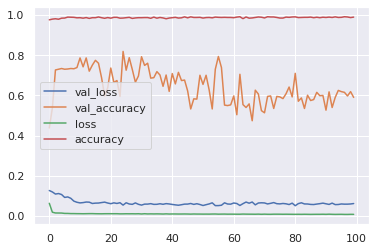

In [71]:
pd.DataFrame(result.history).plot();

In [72]:
y_pred = pd.DataFrame(rnn.predict(X_test), columns=y_test.columns, index=y_test.index)
y_pred.head()

,BEP,EIX,NEE,PCG,SRE,TSLA
1696,0.285135,0.957983,0.361819,0.939602,0.576034,0.161111
1697,0.285503,0.953943,0.356883,0.934533,0.569441,0.164254
1698,0.288189,0.962260,0.358177,0.938263,0.573876,0.168745
1699,0.295646,0.946062,0.352624,0.926814,0.568129,0.170685
1700,0.290802,0.943860,0.349009,0.924399,0.564780,0.172350


In [73]:
y_pred_act = pd.DataFrame(scaler.inverse_transform(y_pred), columns=y_test.columns, index=y_test.index)

In [74]:
y_pred_act = np.around(y_pred_act)
y_pred_act.head()

,BEP,EIX,NEE,PCG,SRE,TSLA
1696,30.0,80.0,133.0,67.0,112.0,262.0
1697,30.0,80.0,132.0,67.0,111.0,267.0
1698,30.0,81.0,132.0,67.0,112.0,274.0
1699,30.0,80.0,131.0,67.0,111.0,277.0
1700,30.0,80.0,130.0,66.0,111.0,280.0


In [75]:
y_pred_act.describe()

,BEP,EIX,NEE,PCG,SRE,TSLA
count,834.000000,834.000000,834.000000,834.000000,834.000000,834.000000
mean,35.020382,71.353714,172.910065,44.553955,119.052757,354.834534
std,6.120900,7.417627,26.383268,13.981815,11.068689,179.169312
min,25.000000,51.000000,129.000000,17.000000,95.000000,171.000000
25%,31.000000,65.000000,150.000000,32.000000,112.000000,271.250000
50%,33.000000,71.000000,166.000000,45.000000,115.000000,309.000000
75%,37.000000,79.000000,197.750000,53.000000,125.000000,344.000000
max,54.000000,86.000000,233.000000,70.000000,147.000000,1395.000000


In [76]:
y_test_act = pd.DataFrame(scaler.inverse_transform(y_test), columns=y_test.columns, index=y_test.index)
y_test_act.head()

,BEP,EIX,NEE,PCG,SRE,TSLA
1696,29.250000,80.500000,131.100006,67.190002,111.599999,270.220001
1697,29.320000,80.900002,131.259995,67.339996,112.070000,277.450012
1698,29.610001,79.820000,130.550003,66.629997,111.279999,277.380005
1699,29.540001,79.489998,128.130005,66.360001,110.230003,277.920013
1700,29.730000,79.610001,128.369995,66.360001,110.500000,278.299988


In [77]:
test_mae = mean_absolute_error(y_pred_act, y_test_act)
test_mae

10.595733464476018

In [78]:
y_test.columns

Index(['BEP', 'EIX', 'NEE', 'PCG', 'SRE', 'TSLA'], dtype='object')

In [79]:
test_mae1 = mean_absolute_error(y_pred_act.iloc[:,0], y_test_act.iloc[:,0])
test_mae2 = mean_absolute_error(y_pred_act.iloc[:,1], y_test_act.iloc[:,1])
test_mae3 = mean_absolute_error(y_pred_act.iloc[:,2], y_test_act.iloc[:,2])
test_mae4 = mean_absolute_error(y_pred_act.iloc[:,3], y_test_act.iloc[:,3])
test_mae5 = mean_absolute_error(y_pred_act.iloc[:,4], y_test_act.iloc[:,4])
test_mae6 = mean_absolute_error(y_pred_act.iloc[:,5], y_test_act.iloc[:,5])

In [80]:
print('BEP =',test_mae1)
print('EIX =',test_mae2)
print('NEE =',test_mae3)
print('PCG =',test_mae4)
print('SRE =',test_mae5)
print('TSLA =',test_mae6)

BEP = 0.8427817645323742
EIX = 3.78959227177458
NEE = 13.998357248081525
PCG = 10.87682253026139
SRE = 3.7547840982254184
TSLA = 30.312062873980814
